# Intel MPI Benchmarks

Results of selected MPI1 tests from the [IMB benchmark suite](https://software.intel.com/content/www/us/en/develop/documentation/imb-user-guide/top.html).

All tests use two nodes:
- pingpong: Single process per node
- uniband: Multiple processes per node, communicating in pairs split across nodes
- biband: As for uniband but communication initiated in both directions
- alltoall: As many processes on each node as there are (hardware) cores

Tests use a range of message sizes and report bandwidth and/or latency.

In [1]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, Markdown, HTML

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../../reframe', '../../')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

In [2]:
# set notebook width to 90%
display(HTML("<style>.container { width:90% !important; }</style>"))

# Bandwidth/latency vs message size

The plots below show results vs message size for selected tests:
- pingpong
- 2x process runs of uniband and biband

Results are for the most-recent test on each system/partition/environment combination.

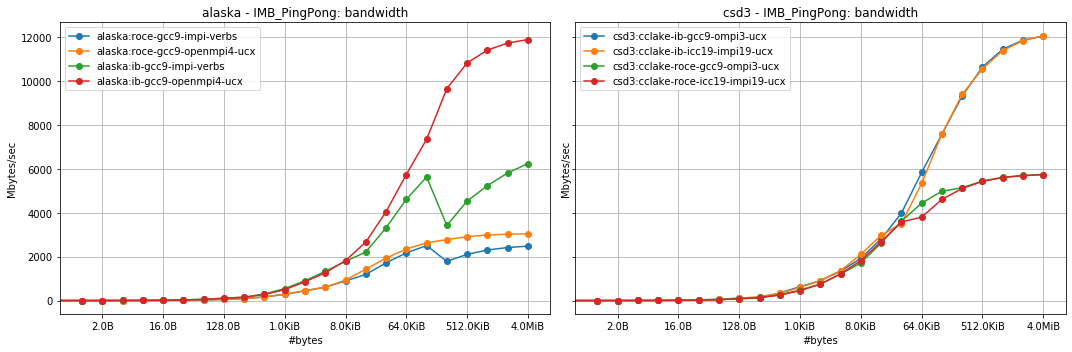

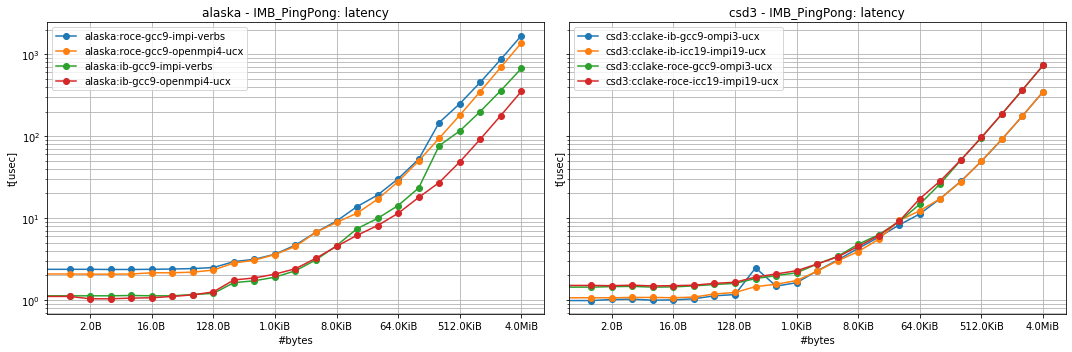

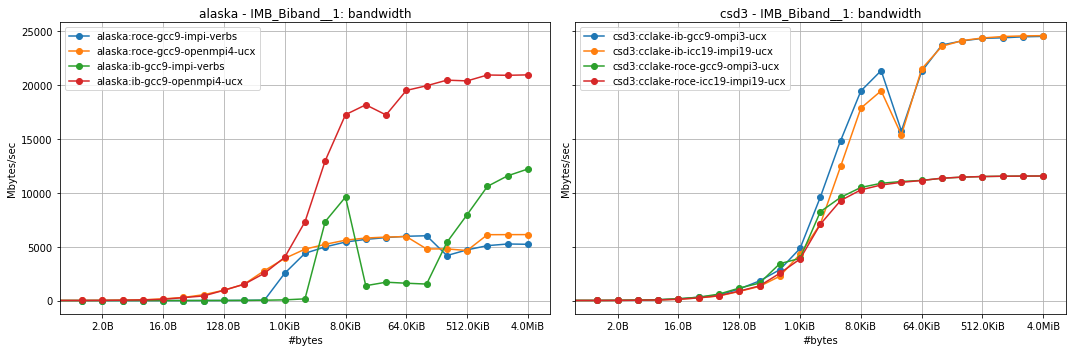

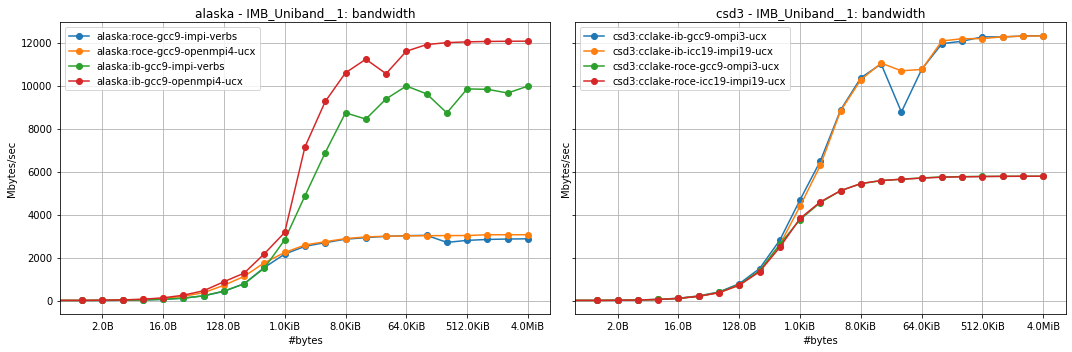

In [13]:
# constants:
Gb_to_MB = 125.0

# def groupby(paths, meta, var):
#     curr = None
#     for ix, p in enumerate(paths):
#         m = meta[ix]
#         if m[var] != curr:
#             if curr is not None:
#                 yield (outpaths, outmeta)
#             curr = m[var]
#             outpaths = []
#             outmeta = []
#         outpaths.append(p)
#         outmeta.append(m)
    
#     yield (outpaths, outmeta)

for (test, column, param) in [('IMB_PingPong', 'Mbytes/sec', 'bandwidth'),
                              ('IMB_PingPong', 't[usec]', 'latency'),
                              ('IMB_Biband__1', 'Mbytes/sec', 'bandwidth'),
                              ('IMB_Uniband__1', 'Mbytes/sec', 'bandwidth'),
                             ]:
    
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../../output/', test=test) # will be sorted by system
    meta = [modules.utils.parse_path_metadata(p) for p in paths]
    systems = sorted(set(m['sysname'] for m in meta))
    fig, axes = plt.subplots(nrows=1, ncols=len(systems), figsize=(15, 5), sharey=True)
    for ix, path in enumerate(paths):
        datas = modules.imb.read_imb_out(path)
        assert len(datas) == 1
        data = datas[list(datas.keys())[0]]
        label = '%s:%s' % (meta[ix]['sysname'], meta[ix]['partition'])
        ax_idx = systems.index(meta[ix]['sysname'])
        axes[ax_idx].plot(data['#bytes'], data[column], 'o-', data=data, label=label)
            
    # format plot:
    for ax_ix, ax in enumerate(axes):
        ax.set_xscale('log', basex=2)
        if param == 'latency':
            ax.set_yscale('log', basey=10)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
        ax.grid(True, which="both")
        ax.set_xlabel('#bytes')
        ax.set_ylabel(column)
        ax.set_title('%s - %s: %s' % (systems[ax_ix], test, param)) # meta index doesn't matter, all the same
        ax.legend()
    plt.tight_layout()


# Maximum bandwidth

The table below shows the maximum bandwidth for the above plots, as a % of line-rate (requires `systems/sysinfo.json` to have an entry for `interconnect_Gb` for each system).

In [11]:
BW_TESTS = ['IMB_PingPong', 'IMB_Uniband__1', 'IMB_Biband__1', ]
perflogs = [modules.utils.load_perf_logs('../../perflogs', pat) for pat in BW_TESTS]
perflogs = pd.concat(perflogs).reset_index(drop=True)
df = modules.plots.tabulate_last_perf_vs(perflogs, 'testname', 'max_bandwidth')
linerates = {}
for test in BW_TESTS:
    linerates[test] = {}
    for c in df.columns:
        syspart = c.replace('-', ':', 1) # e.g. alaska-ib-gcc9-impi-verbs-imb -> alaska:ib-gcc9-impi-verbs-imb
        linerates[test][c] = modules.utils.get_sysinfo(syspart)['interconnect_Gb'] * Gb_to_MB * (2 if 'Bi' in test else 1)
df = 100 * (df / pd.DataFrame(linerates).transpose())
display(df.transpose().style.set_precision(1).set_caption('Max bandwidth as % of linerate - single process per node'))

,IMB_Biband__1,IMB_PingPong,IMB_Uniband__1
case,,,
alaska-ib-gcc9-impi-verbs-imb,48.9,49.9,79.9
alaska-ib-gcc9-openmpi4-ucx-imb,83.8,95.1,96.6
alaska-roce-gcc9-impi-verbs-imb,96.3,80.1,97.1
alaska-roce-gcc9-openmpi4-ucx-imb,98.0,97.4,98.0
csd3-cclake-ib-gcc9-ompi3-ucx-imb,98.1,96.4,98.6
csd3-cclake-ib-icc19-impi19-ucx-imb,98.4,96.6,98.5
csd3-cclake-roce-gcc9-ompi3-ucx-imb,92.5,91.8,92.6
csd3-cclake-roce-icc19-impi19-ucx-imb,92.5,91.8,92.6


# Max Bandwidth vs Number of Processes per Node

The plots below show the maximum bandwidth over all message sizes for tests using varying numbers of processes per node. Results are for the most-recent test on each system/partition/environment combination.

The tabular data shows the maximum value on each curve, i.e. the maximum over both message size and numbers of processes, as a percentage of linerate (requires `systems/sysinfo.json` to have an entry for `interconnect_Gb` for each system).

,IMB_Uniband,IMB_Biband
case,,
alaska:ib-gcc9-impi-verbs,99.0,82.6
alaska:ib-gcc9-openmpi4-ucx,99.1,82.9
alaska:roce-gcc9-impi-verbs,98.0,97.9
alaska:roce-gcc9-openmpi4-ucx,98.0,98.0
csd3:cclake-ib-gcc9-ompi3-ucx,98.8,98.6
csd3:cclake-ib-icc19-impi19-ucx,98.8,98.6
csd3:cclake-roce-gcc9-ompi3-ucx,92.6,92.6
csd3:cclake-roce-icc19-impi19-ucx,92.6,92.6


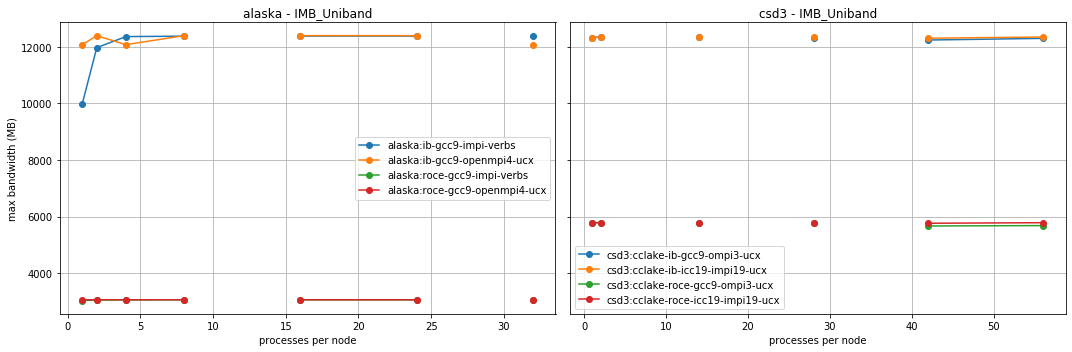

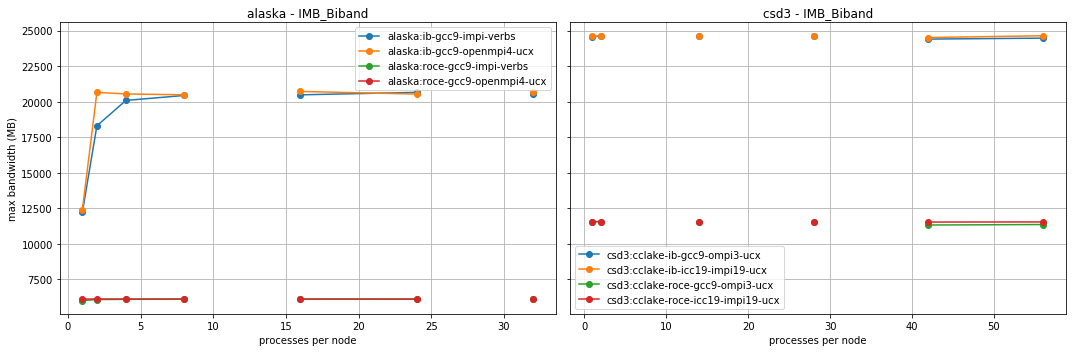

In [12]:
maxes = []
linerates = {}
for test in ['IMB_Uniband_*', 'IMB_Biband_*']:
    
    df = modules.utils.tabulate_last_perf(test, 'procs_per_node', 'max_bandwidth')
    
    # calculate max value for each system:partition, i.e. over number of processes:
    sys_maxes = df.max()
    sys_maxes.name = test[:-2]
    maxes.append(sys_maxes)
    
    # calculate linerates:
    test_linerates = dict((syspart, modules.utils.get_sysinfo(syspart)['interconnect_Gb'] * Gb_to_MB * (2 if 'Bi' in test else 1)) for syspart in sys_maxes.index)
    linerates[test[:-2]] = test_linerates
    
    # plot by system:
    sys_cols = {} # group columns by system: sysname -> [colA, colB, ...]
    for c in df.columns:
        sysname = c.split(':')[0]
        sys_cols.setdefault(sysname, []).append(c)
    fig, axes = plt.subplots(nrows=1, ncols=len(sys_cols), figsize=(15, 5), sharey=True)
    for sys_idx, (sys, cols) in enumerate(sys_cols.items()):
        sys_df = df.loc[:, cols]
        sys_df.plot(ax=axes[sys_idx], grid=True, style='o-')
    
    # format plot:
    for ix_ax, ax in enumerate(axes):
        ax.set_xlabel('processes per node')
        ax.set_ylabel('max bandwidth (MB)')
        plt.tight_layout()
        ax.set_title('%s - %s' % (list(sys_cols.keys())[ix_ax], test[:-2]))
        ax.legend()

# calculate max values as % of linerate
maxes = pd.concat(maxes, axis=1)
#display(maxes)
linerates = pd.DataFrame(linerates)
#display(linerates)
bw_perf = 100 * maxes/linerates
display(bw_perf.style.set_precision(1).set_caption('Max bandwidth as % of linerate - multiple processes per node'))